## Attribute Information
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_auc_score, f1_score, roc_curve, precision_score, recall_score,auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


In [3]:
import klib

In [4]:
df = pd.read_csv('../data/cirrhosis(cleaned).csv', index_col='ID')

In [5]:
df.head()

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,0,2,1,1.0,1.0,1.0,2,400,59.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,2,2,1,0.0,1.0,1.0,0,4500,56.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,0,2,0,0.0,0.0,0.0,1,1012,70.0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,0,2,1,0.0,1.0,1.0,1,1925,55.0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1,1,1,0.0,1.0,1.0,0,1504,38.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


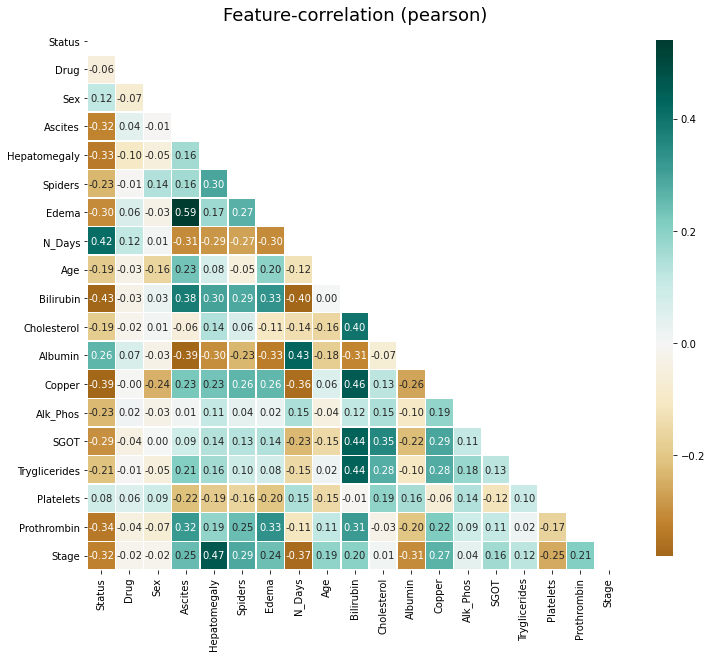

In [6]:
klib.corr_plot(df)
None

### _No significant correlation between our features other than some form of correlation between edema and ascites_

In [7]:
df.isna().sum()

Status             0
Drug               0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
N_Days             0
Age                0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [8]:
df.dropna(subset=['Stage'],inplace = True)

In [9]:
df.shape

(412, 19)

In [10]:
to_plot = df.drop(columns='Alk_Phos')

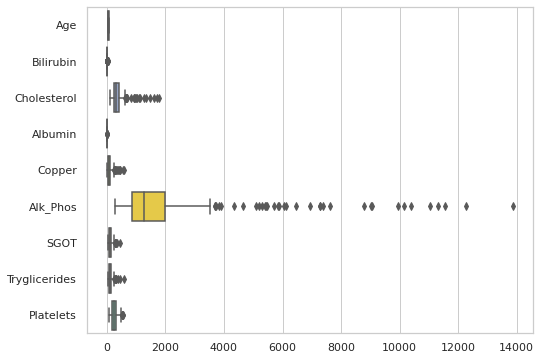

In [11]:
plt.figure(figsize=[8,6])
sns.set_theme(style="whitegrid")
sns.boxplot(data = df.iloc[:, 8:-2], orient="h", palette="Set2")
plt.show()

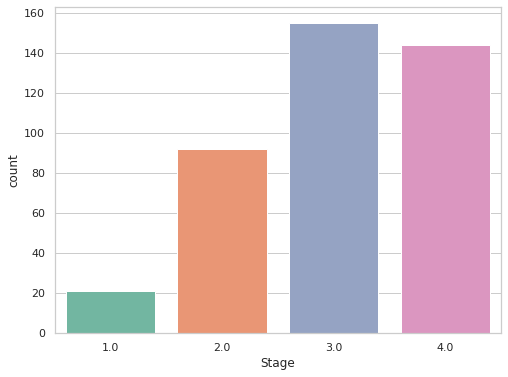

In [12]:
plt.figure(figsize=[8,6])
sns.countplot(data = df, x='Stage',palette="Set2")
plt.show()

### _I will perform KNN imputer for the Nan values cause I don't want to reduce my sample size further since I am planing to drop some outliers_

In [13]:
#performing imputation for nan Values

imp= KNNImputer()

dff = imp.fit_transform(df)

dff = pd.DataFrame(dff)

dff.columns = df.columns

In [14]:
dff.head()

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,400.0,59.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2.0,2.0,1.0,0.0,1.0,1.0,0.0,4500.0,56.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1012.0,70.0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,0.0,2.0,1.0,0.0,1.0,1.0,1.0,1925.0,55.0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1504.0,38.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


### _Dropping outliers that are greater than 3 times the standard deviation and plotting the results_

In [15]:
for column in dff.columns:
    dff=dff[np.abs(dff[column]-dff[column].mean())<=(3*dff[column].std())]
    

In [16]:
dff.shape

(330, 19)

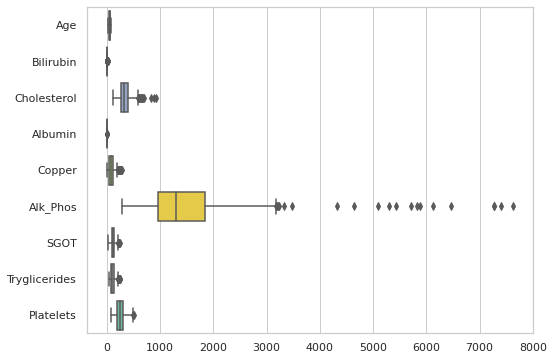

In [17]:
plt.figure(figsize=[8,6])
sns.set_theme(style="whitegrid")
sns.boxplot(data = dff.iloc[:, 8:-2], orient="h", palette="Set2")
plt.show()

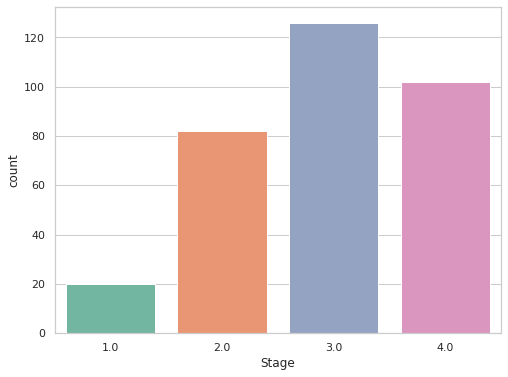

In [18]:
plt.figure(figsize=[8,6])
sns.countplot(data = dff, x='Stage',palette="Set2")
plt.show()

In [19]:
dff.shape

(330, 19)

### _After dropping the outliers I see that my sample is reduced by 100 rows and the classes are still imbalanced. So, a good idea would be to use an oversampling technique in order to balance our classes. Let's analyse our data a little further first._

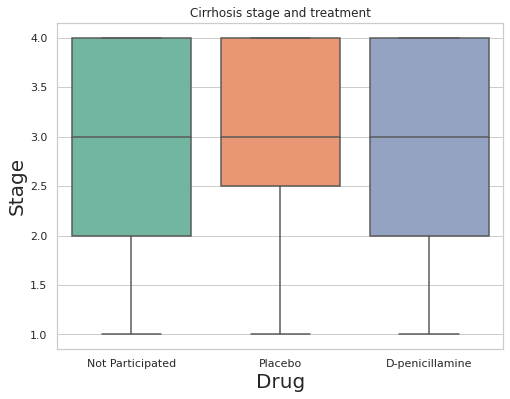

In [20]:
plt.figure(figsize=(8, 6))
plt.title('Cirrhosis stage and treatment')

ax = sns.boxplot(x=dff['Drug'], y=dff['Stage'], palette="Set2")
ax.set_xticklabels( ['Not Participated','Placebo','D-penicillamine'])
plt.xlabel('Drug',fontsize=20)
plt.ylabel('Stage',fontsize=20)

plt.show()

### _We see that those who were treated with placebos are mainly in the later stages of Cirhossis_

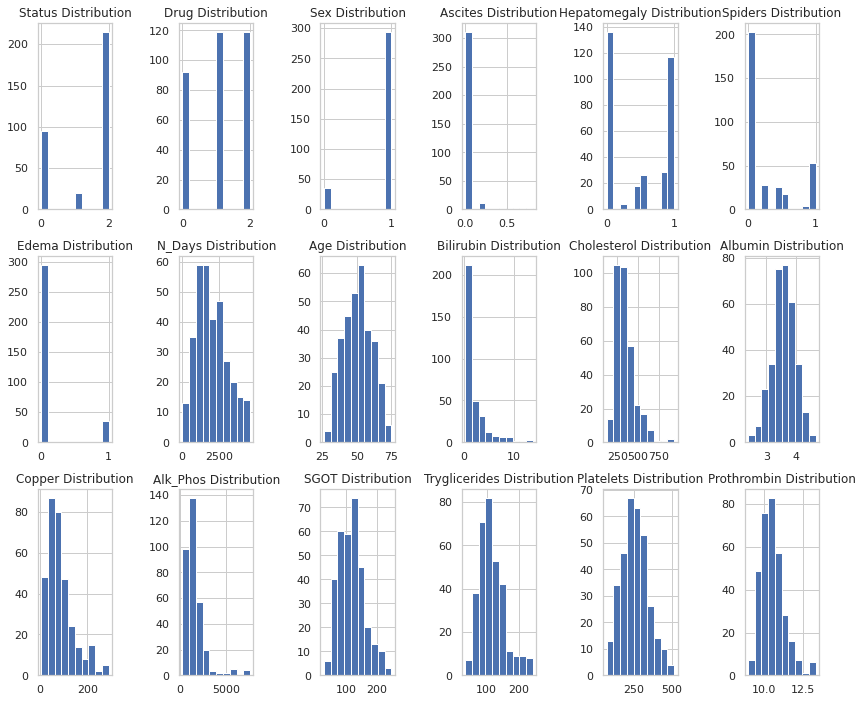

In [21]:
c=1
plt.figure(figsize=(14, 12))
for col in list(dff.iloc[:,:-1].columns):
        plt.subplot(3,6,c)
        plt.subplots_adjust(wspace=.9, hspace=.25)
        name = str(col) + ' Distribution'
        plt.title(name)
        plt.hist(dff[col])
        c += 1

plt.show()

### _After seeing the distributions of our variables we see that we're going to need some form of scaling for our problem.  Let's split and balance the dataset first_

In [22]:
X = dff.drop('Stage', axis=1)
y= dff['Stage']

In [23]:
X_train, X_test,y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

In [24]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((264, 18), (66, 18), (264,), (66,))

In [25]:
#performing oversampling to balance the data

balanced = SMOTE(random_state=0)
bal_X,bal_y=balanced.fit_resample(X_train, y_train)

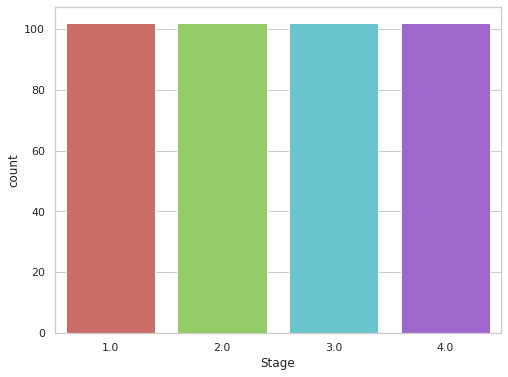

In [26]:
plt.figure(figsize=[8,6])
sns.countplot( x ='Stage', data=pd.DataFrame(bal_y), palette = 'hls')
plt.show()

In [27]:
bal_X.shape, bal_y.shape

((408, 18), (408,))

In [28]:
rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()
nb = GaussianNB()
gb = GradientBoostingClassifier()

### _Since we still have some outliers it might be best to use the robust scaler to scale our data._

In [29]:
SS = StandardScaler()

In [30]:
rf_pipe = Pipeline([('Standard Scaler', SS), ("RandomForest", rf)])
gb_pipe = Pipeline([('Standard Scaler', SS), ("GradientBoost", gb)])
lr_pipe = Pipeline([('Standard Scaler', SS), ("LogisticRegression", lr)])
knn_pipe = Pipeline([('Standard Scaler', SS), ("KNeighborsClassifier", knn)])
nb_pipe = Pipeline([('Standard Scaler', SS), ("GaussianNB", nb)])

In [31]:
clfs = [knn_pipe,gb_pipe,nb_pipe,lr_pipe,rf_pipe]

records=pd.DataFrame(columns=["Model","AUC Score","Precision","Recall","F1 Score"])


for clf in clfs:
    
    clf.fit(bal_X, bal_y)
    
    records = records.append(
    {
        'Model': clf.get_params()['steps'][1][0],
        'AUC Score': round(roc_auc_score(y_test,clf.predict_proba(X_test), multi_class='ovr',average='macro'),3),
        'Precision':round(precision_score(y_test, clf.predict(X_test),average='macro'),3),
        'Recall':round(recall_score(y_test, clf.predict(X_test), average='macro'),3),
        'F1 Score':round(f1_score(y_test, clf.predict(X_test), average='macro'),3)
    },
    ignore_index=True)

records

,Model,AUC Score,Precision,Recall,F1 Score
0,KNeighborsClassifier,0.663,0.486,0.456,0.435
1,GradientBoost,0.681,0.436,0.422,0.417
2,GaussianNB,0.652,0.351,0.388,0.343
3,LogisticRegression,0.725,0.425,0.449,0.408
4,RandomForest,0.692,0.449,0.493,0.457


In [32]:
X_cat = df.iloc[:,:7]
X_num = df.iloc[:,7:]

### _Performing a different imputation approach with KNN for categorical and SimpleImputer for numerical_

In [33]:
imp= KNNImputer()

df1 = imp.fit_transform(X_cat)

df1 = pd.DataFrame(df1)

df1.columns = X_cat.columns

In [34]:
imp = SimpleImputer()

df2 = imp.fit_transform(X_num)

df2 = pd.DataFrame(df2)



In [35]:
df2.columns = X_num.columns

In [36]:
dff1 = pd.concat([df1,df2], axis=1)

In [37]:
for column in dff.columns:
    dff1=dff1[np.abs(dff1[column]-dff1[column].mean())<=(3*dff1[column].std())]

In [38]:
X1 = dff1.drop('Stage', axis=1)
y1 = dff1['Stage']

In [39]:
X_train1, X_test1,y_train1, y_test1 = train_test_split(
    X1, y1, test_size=0.2, random_state=42, shuffle=True)

In [40]:
balanced = SMOTE(random_state=0)
bal_X1,bal_y1=balanced.fit_resample(X_train1, y_train1)


In [41]:
clfs = [knn_pipe,gb_pipe,nb_pipe,lr_pipe,rf_pipe]

records=pd.DataFrame(columns=["Model","AUC Score","Precision","Recall","F1 Score"])


for clf in clfs:
    
    clf.fit(bal_X1, bal_y1)
    
    records = records.append(
    {
        'Model': clf.get_params()['steps'][1][0],
        'AUC Score': round(roc_auc_score(y_test1,clf.predict_proba(X_test1), multi_class='ovr',average='macro'),3),
        'Precision':round(precision_score(y_test1, clf.predict(X_test1),average='macro'),3),
        'Recall':round(recall_score(y_test1, clf.predict(X_test1), average='macro'),3),
        'F1 Score':round(f1_score(y_test1, clf.predict(X_test1), average='macro'),3)
    },
    ignore_index=True)

records

,Model,AUC Score,Precision,Recall,F1 Score
0,KNeighborsClassifier,0.692,0.428,0.497,0.427
1,GradientBoost,0.697,0.364,0.377,0.359
2,GaussianNB,0.694,0.406,0.470,0.409
3,LogisticRegression,0.721,0.409,0.430,0.390
4,RandomForest,0.715,0.408,0.388,0.393


### _The different approach produced overall better results_

In [58]:
records=pd.DataFrame(columns=["Model","Grid Score(AUC scoring)"])

In [59]:
param_grid = [{'RandomForest__n_estimators': [3, 10, 30, 50, 75, 100], 
               'RandomForest__criterion': ['gini', 'entropy'], 
               'RandomForest__max_depth': [1, 2, 3,4, 6, 8, 10, 20] }]

grid_search = GridSearchCV(rf_pipe, param_grid, cv = 5, scoring = 'roc_auc_ovr', return_train_score = True)

grid_search.fit(bal_X1, bal_y1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Standard Scaler', StandardScaler()),
                                       ('RandomForest',
                                        RandomForestClassifier())]),
             param_grid=[{'RandomForest__criterion': ['gini', 'entropy'],
                          'RandomForest__max_depth': [1, 2, 3, 4, 6, 8, 10, 20],
                          'RandomForest__n_estimators': [3, 10, 30, 50, 75,
                                                         100]}],
             return_train_score=True, scoring='roc_auc_ovr')

In [60]:
grid_search.best_params_, grid_search.best_score_

({'RandomForest__criterion': 'gini',
  'RandomForest__max_depth': 20,
  'RandomForest__n_estimators': 75},
 0.8758501289521444)

In [61]:
records = records.append(
    {
        'Model': 'Random Forest',
        'Grid Score(AUC scoring)': round(grid_search.score(X_test, y_test),3)
        
    },
    ignore_index=True)

In [62]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
lr_params = {'LogisticRegression__solver': ['sag', 'saga', 'liblinear'],
                 'LogisticRegression__C': np.logspace(-3, 1, 5),
                 'LogisticRegression__penalty': ['l1', 'l2', 'elasticnet'],
                 'LogisticRegression__class_weight': ['balanced', None]
                }

grid_search = GridSearchCV(lr_pipe, lr_params, cv = 5, scoring = 'roc_auc_ovr', return_train_score = True)

grid_search.fit(bal_X1, bal_y1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Standard Scaler', StandardScaler()),
                                       ('LogisticRegression',
                                        LogisticRegression())]),
             param_grid={'LogisticRegression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'LogisticRegression__class_weight': ['balanced', None],
                         'LogisticRegression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'LogisticRegression__solver': ['sag', 'saga',
                                                        'liblinear']},
             return_train_score=True, scoring='roc_auc_ovr')

In [64]:
grid_search.best_params_, grid_search.best_score_

({'LogisticRegression__C': 1.0,
  'LogisticRegression__class_weight': 'balanced',
  'LogisticRegression__penalty': 'l1',
  'LogisticRegression__solver': 'saga'},
 0.7306376763141975)

In [65]:
records = records.append(
    {
        'Model': 'Logistic Regression',
        'Grid Score(AUC scoring)': round(grid_search.score(X_test, y_test),3)
        
    },
    ignore_index=True)

In [66]:
gb_params = {'GradientBoost__loss': ['deviance', 'exponential'],
                 'GradientBoost__learning_rate': np.logspace(-4, 1, 4),
                 'GradientBoost__n_estimators': range(60, 160, 20),
                 'GradientBoost__min_samples_split': range(2, 8, 2),
                 'GradientBoost__min_samples_leaf': range(1, 5),
                 'GradientBoost__max_features': ['sqrt', 'log2']}

grid_search = GridSearchCV(gb_pipe, gb_params, cv = 5, scoring = 'roc_auc_ovr', n_jobs=-1, return_train_score = True)

grid_search.fit(bal_X1, bal_y1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Standard Scaler', StandardScaler()),
                                       ('GradientBoost',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'GradientBoost__learning_rate': array([1.00000000e-04, 4.64158883e-03, 2.15443469e-01, 1.00000000e+01]),
                         'GradientBoost__loss': ['deviance', 'exponential'],
                         'GradientBoost__max_features': ['sqrt', 'log2'],
                         'GradientBoost__min_samples_leaf': range(1, 5),
                         'GradientBoost__min_samples_split': range(2, 8, 2),
                         'GradientBoost__n_estimators': range(60, 160, 20)},
             return_train_score=True, scoring='roc_auc_ovr')

In [67]:
grid_search.best_params_, grid_search.best_score_

({'GradientBoost__learning_rate': 0.21544346900318845,
  'GradientBoost__loss': 'deviance',
  'GradientBoost__max_features': 'log2',
  'GradientBoost__min_samples_leaf': 4,
  'GradientBoost__min_samples_split': 2,
  'GradientBoost__n_estimators': 120},
 0.8556131594867387)

In [68]:
records = records.append(
    {
        'Model': 'Gradient Boosting',
        'Grid Score(AUC scoring)': round(grid_search.score(X_test, y_test),3)
        
    },
    ignore_index=True)

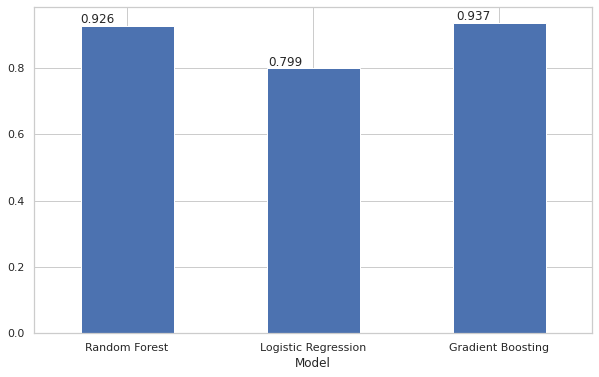

In [69]:
ax = records.plot.bar(x='Model', y='Grid Score(AUC scoring)', rot=0,figsize=(10,6), legend=None)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.010, p.get_height() * 1.010))
plt.show()

In [74]:
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

In [77]:
res = grid_search.predict(X_test)

In [80]:
cm = pd.crosstab(y_test, res, rownames=['Actual'], colnames=['Predicted'], margins=False)

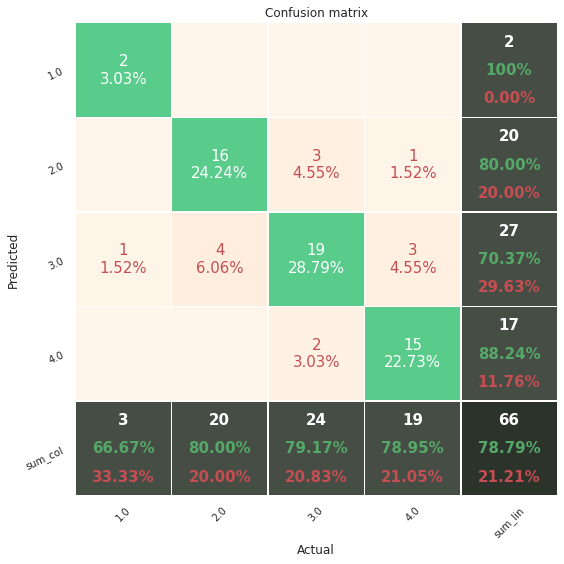

In [82]:
pretty_plot_confusion_matrix(cm, fz=15)

In [84]:
import scikitplot as skplt

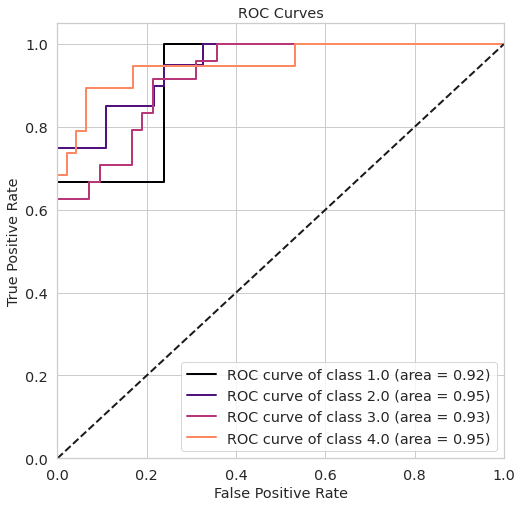

In [92]:
probs = grid_search.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, probs,figsize=[8,8], cmap='magma',
                       plot_macro=False,plot_micro=False,text_fontsize='large')
plt.show()

In [70]:
import shap

In [71]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [72]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

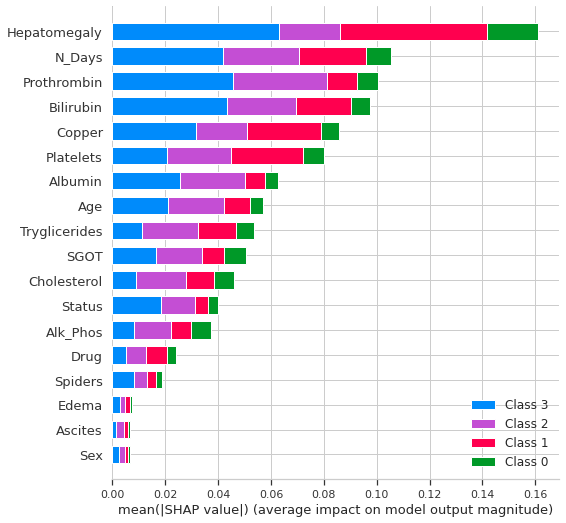

In [73]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [95]:
import pickle
import os

In [97]:
filename = os.path.join(os.getcwd(), '..', 'modeling','finalized_model.sav')
pickle.dump(grid_search, open(filename, 'wb'))